In [159]:
import pickle
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch.optim import SGD
import torch.nn.init as init


# --- 1. CONFIGURATION & REPRODUCTIBILITÉ ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {DEVICE}")



Utilisation du device : mps


In [160]:
def preprocess_retina(img_tensor):
    """
    Retourne 2 canaux utiles :
      - canal 0 : grayscale
      - canal 1 : normalised (R - B)
    """
    r = img_tensor[0]
    g = img_tensor[1]   # inutile mais requis pour gray
    b = img_tensor[2]

    # 1) grayscale
    gray = 0.299*r + 0.587*g + 0.114*b

    # 2) diff R-B normalisé
    diff = r - b
    diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-6)

    # 3) normalisation locale de R et B
    r_n = (r - r.min()) / (r.max() - r.min() + 1e-6)
    b_n = (b - b.min()) / (b.max() - b.min() + 1e-6)

    s = r + b
    s = (s - s.min()) / (s.max() - s.min() + 1e-6)
  
    return torch.stack([r_n, b_n, s, diff], dim=0)

In [161]:
# --- 2. DÉFINITION DU DATASET ---
class RetinaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Récupération directe depuis vos arrays splittés
        img_arr = self.images[idx]
        
        # Gestion propre du label (évite le warning numpy)
        label = self.labels[idx]
        if hasattr(label, 'item'):
            label = int(label.item())
        else:
            label = int(label)
        
        # Conversion PIL pour les transforms
        img_pil = Image.fromarray(img_arr.astype('uint8'))
        
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)
            
        return img_tensor, label




In [162]:
# --- 4. CHARGEMENT ET SPLIT ---
print("Chargement des données...")
# Remplacez par le bon chemin
TRAIN_PATH = "ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl" 
TEST_PATH = "ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl"

with open(TRAIN_PATH, "rb") as f:
    train_data_raw = pickle.load(f)

with open(TEST_PATH, "rb") as f:
    test_data_raw = pickle.load(f)

X_imgs = train_data_raw["images"].astype(np.float32) 
y = train_data_raw["labels"].reshape(-1)

X_train_imgs, X_val_imgs, y_train, y_val = train_test_split(
    X_imgs, y, test_size=0.2, random_state=0, stratify=y
)
from sklearn.utils.class_weight import compute_class_weight

weights_b = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


Chargement des données...


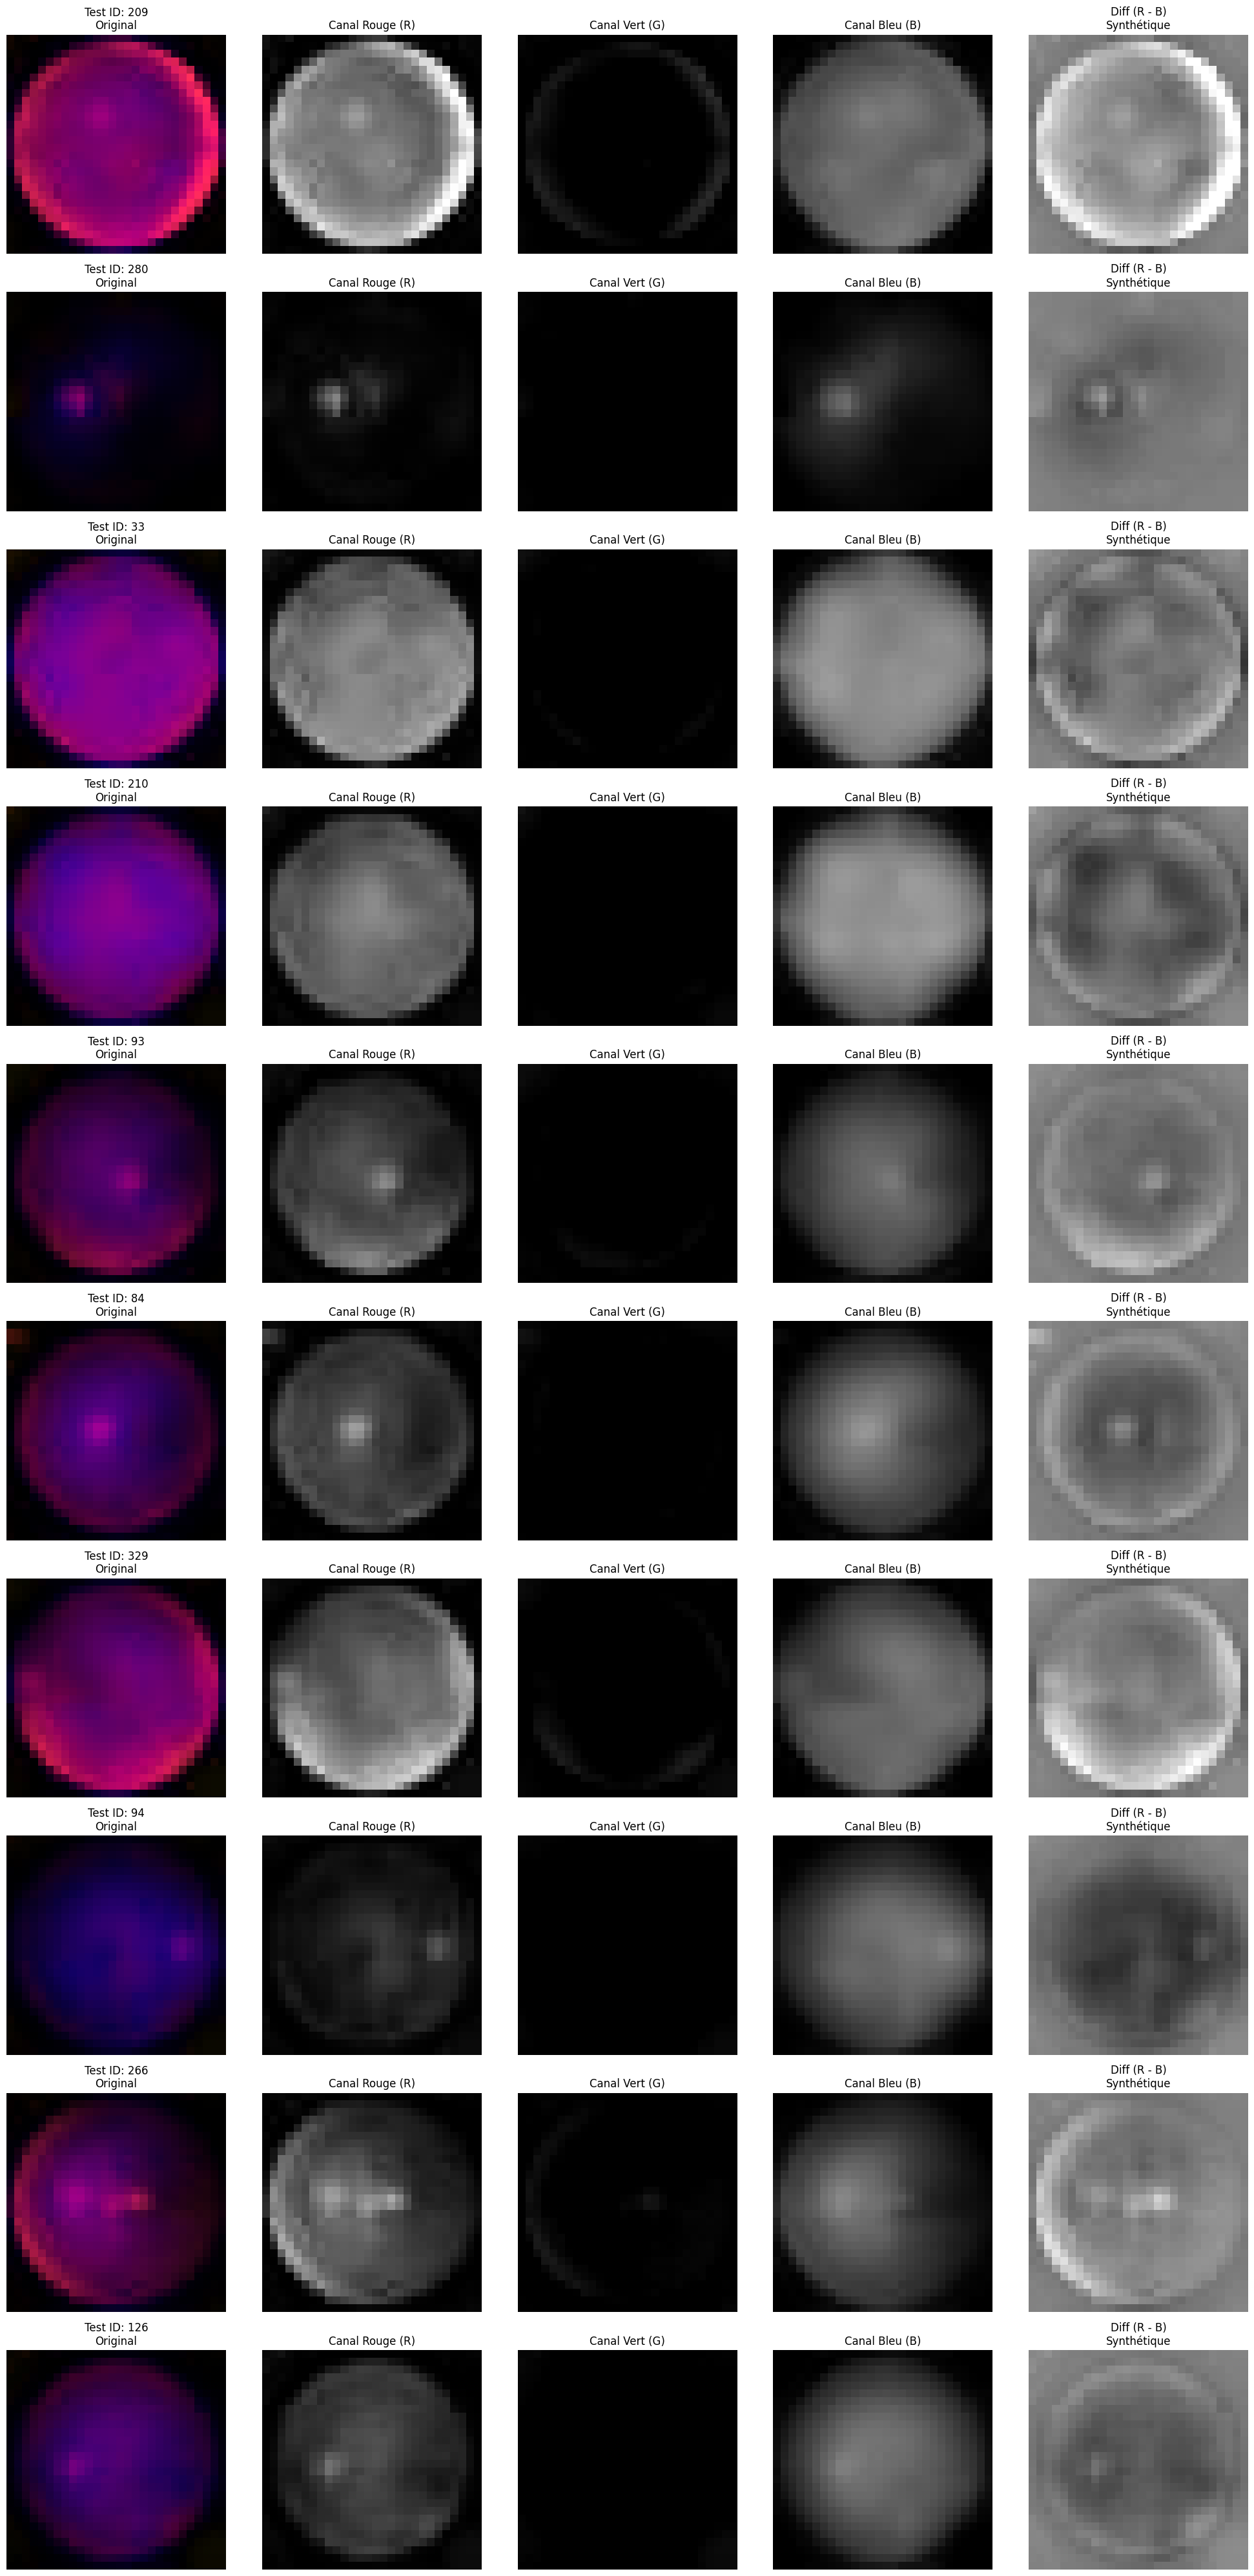

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_channels_test(images, num_samples=5):
    # Si 'images' est le dictionnaire complet (ex: test_data_raw), on extrait le tableau
    if isinstance(images, dict) and 'images' in images:
        images = images['images']
    
    # Sélection aléatoire d'indices
    # On gère le cas où on demande plus d'échantillons qu'il n'y a d'images
    n_total = len(images)
    actual_samples = min(num_samples, n_total)
    indices = np.random.choice(n_total, actual_samples, replace=False)
    
    # On prépare la figure : 5 colonnes
    fig, axes = plt.subplots(actual_samples, 5, figsize=(20, 4 * actual_samples))
    
    # Si on n'a qu'une seule image, axes est 1D, on le force en 2D pour la boucle
    if actual_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, idx in enumerate(indices):
        img = images[idx] # (28, 28, 3)
        
        # Normalisation [0, 1] pour l'affichage matplotlib
        if img.max() > 1.0:
            img = img.astype(float) / 255.0
            
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
        
        # Le canal "Magique" : Différence Rouge - Bleu
        diff = (r - b) + 0.5 
        diff = np.clip(diff, 0, 1)

        # --- Colonne 1 : Original ---
        axes[i, 0].imshow(img)
        # On affiche l'ID pour pouvoir retrouver l'image si besoin
        axes[i, 0].set_title(f"Test ID: {idx}\nOriginal")
        axes[i, 0].axis('off')

        # --- Colonne 2 : Rouge (R) ---
        axes[i, 1].imshow(r, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title("Canal Rouge (R)")
        axes[i, 1].axis('off')

        # --- Colonne 3 : Vert (G) - Probablement vide ---
        axes[i, 2].imshow(g, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title("Canal Vert (G)")
        axes[i, 2].axis('off')

        # --- Colonne 4 : Bleu (B) ---
        axes[i, 3].imshow(b, cmap='gray', vmin=0, vmax=1)
        axes[i, 3].set_title("Canal Bleu (B)")
        axes[i, 3].axis('off')
        
        # --- Colonne 5 : Différence Synthétique ---
        axes[i, 4].imshow(diff, cmap='gray', vmin=0, vmax=1)
        axes[i, 4].set_title("Diff (R - B)\nSynthétique")
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()

# --- LANCER L'OBSERVATION ---
# Attention : assurez-vous de passer le tableau d'images, ou le dictionnaire
# Si 'test_data_raw' est votre dictionnaire chargé par pickle :
visualize_channels_test(test_data_raw['images'], num_samples=10)

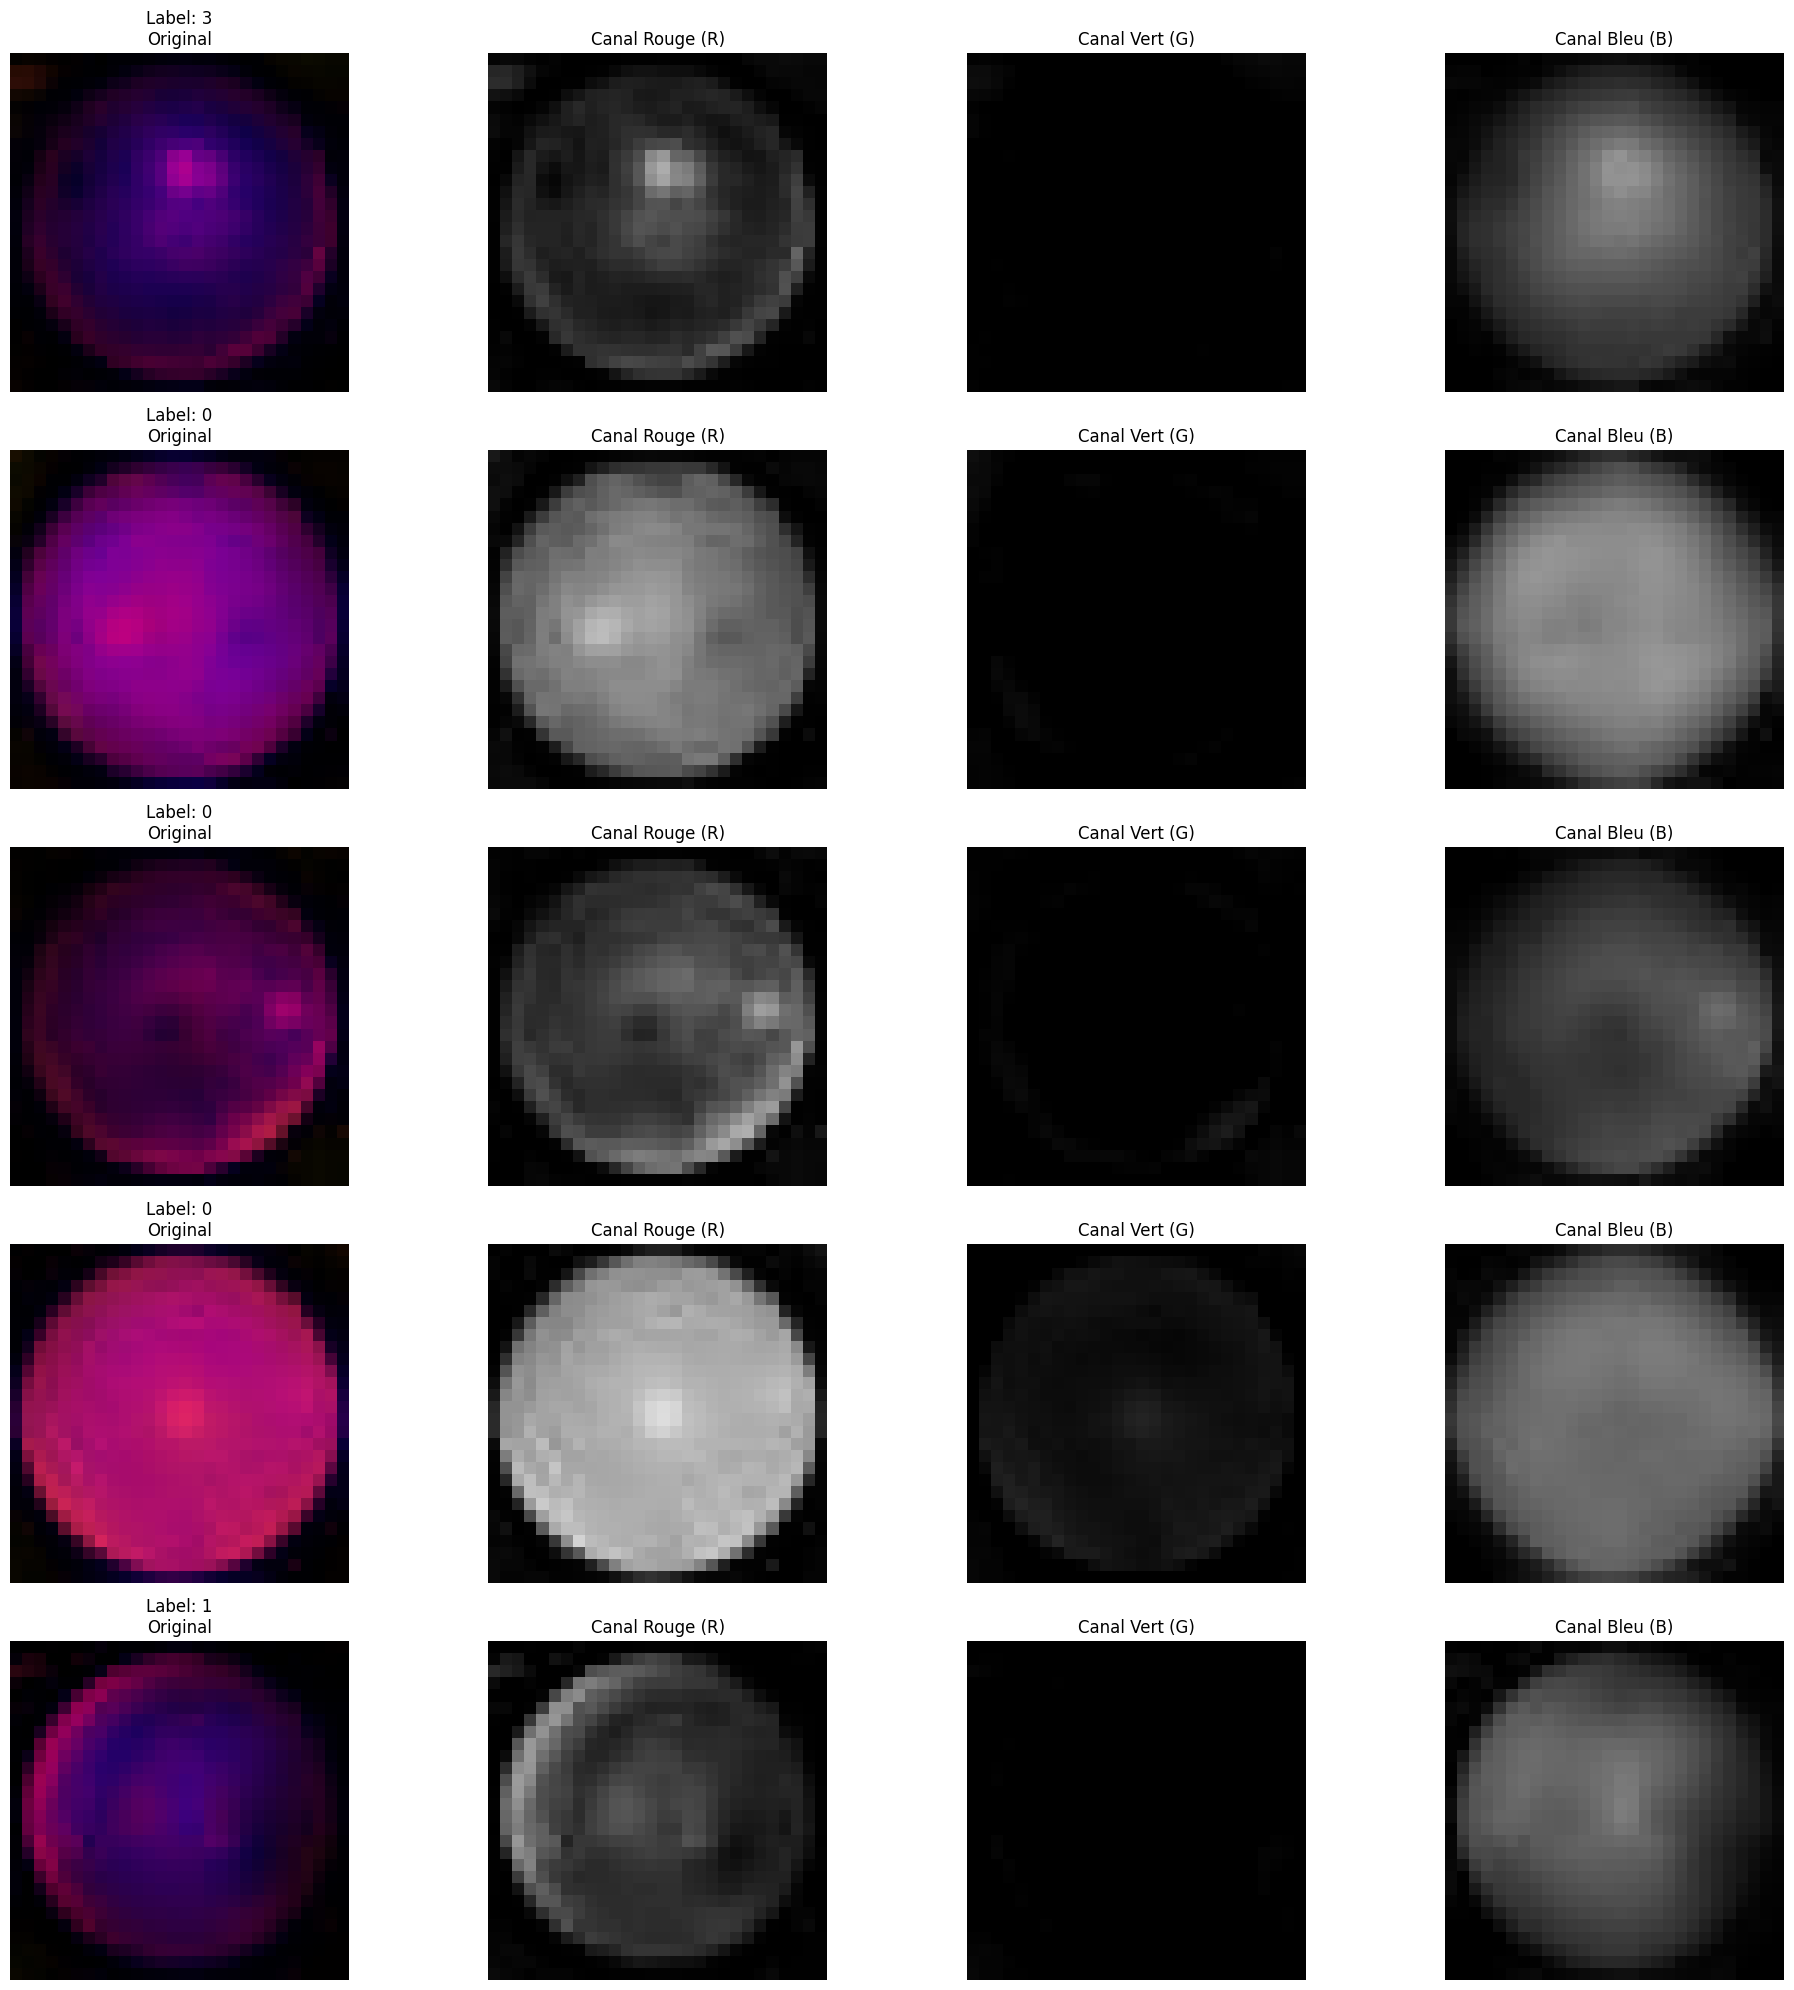

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_channels(images, labels, num_samples=5):
    # Sélection aléatoire d'indices
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    # On prépare la figure : 5 colonnes (Original, R, G, B, Diff)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        img = images[idx] # (28, 28, 3) supposé en uint8 [0-255]
        label = labels[idx]
        
        # Normalisation pour l'affichage si ce n'est pas déjà fait
       
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
        
        # Le canal "Magique" : Différence Rouge - Bleu
        # On ajoute 0.5 pour centrer le gris
        diff = (r - b) + 0.5 
        diff = np.clip(diff, 0, 1)

        # --- Colonne 1 : Original ---
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Label: {label}\nOriginal")
        axes[i, 0].axis('off')

        # --- Colonne 2 : Rouge (Grayscale) ---
        axes[i, 1].imshow(r, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title("Canal Rouge (R)")
        axes[i, 1].axis('off')

        # --- Colonne 3 : Vert (Grayscale) ---
        axes[i, 2].imshow(g, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title("Canal Vert (G)")
        axes[i, 2].axis('off')

        # --- Colonne 4 : Bleu (Grayscale) ---
        axes[i, 3].imshow(b, cmap='gray', vmin=0, vmax=1)
        axes[i, 3].set_title("Canal Bleu (B)")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# --- LANCER L'OBSERVATION ---
# Prenez vos images brutes (X_train_imgs)
visualize_channels(X_train_imgs, y_train, num_samples=5)

TypeError: Invalid shape (400, 28, 28, 3) for image data

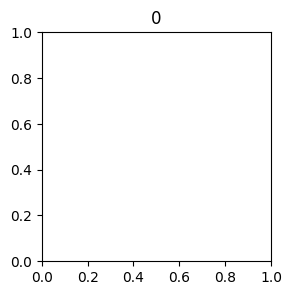

In [ ]:
from skimage import exposure
import cv2

bad_images = []


for i, img in enumerate(test_data_raw['images']):

        img_norm = img 
        
        if img_norm.std() < 0.06:
            bad_images.append(i)
            
        if img_norm.mean() > 0.3:
            bad_images.append(i)

        r, g, b = img_norm[:,:,0], img_norm[:,:,1], img_norm[:,:,2]
        if r.mean() > g.mean() * 1.8 and r.mean() > b.mean() * 1.8:
            bad_images.append(i)
        

mask = np.ones(len(test_data_raw['images']), dtype=bool)

mask[bad_images] = False

n_show = min(40, len(bad_images))

if n_show == 0:
    print("aucune image")

else:
    plt.figure(figsize=(28,28))
    for i,idx in enumerate(bad_images[:n_show]):
        plt.subplot(8, 5, i+1)
        plt.title(y_train[idx])
        plt.imshow(test_data_raw['images'])
        plt.show()



In [ ]:
import numpy as np

def simple_augment(images, labels, target_count=None, noise_std=2.0):
    """
    Équilibre le dataset en augmentant physiquement les classes minoritaires
    jusqu'à atteindre la taille de la classe majoritaire (ou target_count).
    
    Args:
        images: array de shape (N, H, W, C) ou (N, C, H, W)
        labels: array de shape (N,)
        target_count: nombre cible par classe (None = max actuel)
        noise_std: écart-type du bruit gaussien (2.0 par défaut)
    
    Returns:
        X_balanced, y_balanced: datasets équilibrés
    """
    unique_classes, counts = np.unique(labels, return_counts=True)
    max_count = target_count if target_count is not None else np.max(counts)
    
    print(f"Distribution avant : {dict(zip(unique_classes, counts))}")
    print(f"Objectif par classe : {max_count} images")
    
    augmented_images = []
    augmented_labels = []
    
    for cls in unique_classes:
        # Récupérer les images de la classe actuelle
        idx = np.where(labels == cls)[0]
        cls_imgs = images[idx]
        cls_lbls = labels[idx]
        
        # On garde les originaux
        augmented_images.append(cls_imgs)
        augmented_labels.append(cls_lbls)
        
        # Combien en manque-t-il ?
        diff = max_count - len(cls_imgs)
        
        if diff > 0:
            # Choix aléatoire avec replacement
            indices_to_aug = np.random.choice(len(cls_imgs), size=diff, replace=True)
            imgs_to_aug = cls_imgs[indices_to_aug]
            
            # Application des transformations
            new_imgs = []
            for img in imgs_to_aug:
                aug_img = img.astype(np.float32).copy()
                
                # Détection du format (C, H, W) ou (H, W, C)
                if img.shape[0] == 3 or img.shape[0] == 1:  # Format (C, H, W)
                    flip_h_axis, flip_v_axis = 2, 1
                    rot_axes = (1, 2)
                else:  # Format (H, W, C)
                    flip_h_axis, flip_v_axis = 1, 0
                    rot_axes = (0, 1)
                
                # 1. Flip Horizontal (50%)
                if np.random.rand() > 0.5:
                    aug_img = np.flip(aug_img, axis=flip_h_axis)
                
                # 2. Flip Vertical (50%)
                if np.random.rand() > 0.5:
                    aug_img = np.flip(aug_img, axis=flip_v_axis)
                
                # 3. Rotation 90/180/270 (aléatoire)
                k = np.random.randint(0, 4)
                if k > 0:
                    aug_img = np.rot90(aug_img, k=k, axes=rot_axes)
                
                # 4. Bruit gaussien léger
                noise = np.random.normal(0, noise_std, aug_img.shape)
                aug_img = aug_img + noise
                
                # 5. NOUVEAUTÉ : Brightness shift (±10%)
                if np.random.rand() > 0.5:
                    brightness_factor = np.random.uniform(0.9, 1.1)
                    aug_img = aug_img * brightness_factor
                
                # 6. NOUVEAUTÉ : Small random crop + pad (translation)
                if np.random.rand() > 0.6:
                    shift_h = np.random.randint(-2, 3)
                    shift_w = np.random.randint(-2, 3)
                    aug_img = np.roll(aug_img, shift=shift_h, axis=rot_axes[0])
                    aug_img = np.roll(aug_img, shift=shift_w, axis=rot_axes[1])
                
                new_imgs.append(aug_img)
            
            # Clip et conversion
            new_imgs = np.array(new_imgs)
            # Déterminer le max dynamiquement (255 pour uint8, 1.0 pour float normalisé)
            max_val = 255.0 if images.max() > 1.0 else 1.0
            new_imgs = np.clip(new_imgs, 0, max_val)
            
            augmented_images.append(new_imgs)
            augmented_labels.append(np.full(diff, cls))
    
    # Reconstituer le dataset complet
    X_balanced = np.concatenate(augmented_images, axis=0)
    y_balanced = np.concatenate(augmented_labels, axis=0)
    
    # Shuffle pour mélanger originaux et augmentés
    shuffle_idx = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[shuffle_idx]
    y_balanced = y_balanced[shuffle_idx]
    
    print(f"Distribution après : {dict(zip(*np.unique(y_balanced, return_counts=True)))}")
    print(f"Dataset final : {len(y_balanced)} images ({len(y_balanced) - len(labels)} ajoutées)")
    
    return X_balanced.astype(np.float32), y_balanced




In [ ]:
X_train_01 = X_train_imgs / 255.0

IR_MEAN = X_train_01.mean(axis=(0, 1, 2)).tolist()
IR_STD  = X_train_01.std(axis=(0, 1, 2)).tolist()

print(f"IR_MEAN = {IR_MEAN}")
print(f"IR_STD  = {IR_STD}")


IR_MEAN = [0.2134176343679428, 0.005430069752037525, 0.2296530306339264]
IR_STD  = [0.19063284993171692, 0.01690114289522171, 0.16989707946777344]


In [ ]:
#X_train_imgs, y_train = simple_augment(X_train_imgs, y_train, target_count=236)

In [ ]:
# 1. Vérifier les dimensions totales
print(f"Nouvelle forme de X_train : {X_train_imgs.shape}")
print(f"Nouvelle forme de y_train : {y_train.shape}")

# 2. Vérifier la distribution des classes (C'est le plus important !)
# Cela vous confirmera si la classe 4 est bien remontée au niveau de la classe 0
unique_classes, counts = np.unique(y_train, return_counts=True)
print("\nNouvelle distribution des classes :")
print(dict(zip(unique_classes, counts)))

Nouvelle forme de X_train : (864, 28, 28, 3)
Nouvelle forme de y_train : (864,)

Nouvelle distribution des classes :
{np.uint8(0): np.int64(389), np.uint8(1): np.int64(102), np.uint8(2): np.int64(165), np.uint8(3): np.int64(155), np.uint8(4): np.int64(53)}


In [ ]:

train_transform = transforms.Compose([
    #CropCenterCircle(),
    #transforms.RandomRotation(20),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomVerticalFlip(0.5),
    transforms.ColorJitter(
        brightness=0.05,
        contrast=0.05,
        saturation=0.05
    ),


    transforms.GaussianBlur(kernel_size=3, sigma=(0.05, 0.25)),
    transforms.ToTensor(),
    transforms.Lambda(preprocess_retina),
     transforms.Normalize([0.5, 0.5, 0.5, 0.5],
          [0.25, 0.25, 0.25, 0.25])
])

val_transform = transforms.Compose([
    #CropCenterCircle(),
    transforms.ToTensor(),
    transforms.Lambda(preprocess_retina),
     transforms.Normalize([0.5, 0.5, 0.5, 0.5],
          [0.25, 0.25, 0.25, 0.25])

])

train_ds = RetinaDataset(X_train_imgs, y_train, transform=train_transform)
val_ds = RetinaDataset(X_val_imgs, y_val, transform=val_transform)
"""
# Vos loaders (avec le sampler recalculé comme vu précédemment)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

"""

'\n# Vos loaders (avec le sampler recalculé comme vu précédemment)\ntrain_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)\nval_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)\n\n'

In [ ]:
# --- 7. SAMPLER (ÉQUILIBRAGE DOUX) ---
print("Configuration du Sampler...")


class_counts = np.bincount(y_train.astype(int))

class_weights = 1. / np.sqrt(class_counts) 

sample_weights = torch.from_numpy(
    np.array([class_weights[int(y)] for y in y_train])
).double()

sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)



Configuration du Sampler...


In [ ]:
class HeavyNet(nn.Module):
    """A medium sized network that performs very well on MNIST."""

    def __init__(self):
        super().__init__()

        #block1
        self.conv1 = nn.Conv2d(4,32,3,padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,32,3,padding = 1)
        self.bn2 = nn.BatchNorm2d(32)

        #block2
        self.conv3 = nn.Conv2d(32,64,3,padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,64,3,padding = 1)
        self.bn4 = nn.BatchNorm2d(64)

        #fully connected layer for readou
        self.fc1 = nn.Linear(64*7*7,512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512,5)

    def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.max_pool2d(x,2)
      x = F.relu(self.bn3(self.conv3(x)))
      x = F.relu(self.bn4(self.conv4(x)))
      x = F.max_pool2d(x,2)

      x = x.view(x.size(0),-1)
      x = F.relu(self.bn5(self.fc1(x)))
      x = self.dropout(x)
      x = self.fc2(x)
      return x

In [ ]:
class LowResCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(LowResCNN, self).__init__()
        
        # Premier bloc convolutionnel
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.2)
        
        # Deuxième bloc convolutionnel
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.3)
        
        # Troisième bloc convolutionnel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Global Average Pooling (pas besoin de définir, on utilise F.adaptive_avg_pool2d)
        
        # Couches fully connected
        self.fc1 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Premier bloc
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Deuxième bloc
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Troisième bloc
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return x


In [ ]:
# --- 8. ARCHITECTURE (TinyCNN Optimized - GAP) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        

        self.fc1 = nn.Linear(128 * 3 * 3, 256) 
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.3) 
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.max_pool2d(x, 2)
            
            x = F.relu(self.bn3(self.conv3(x)))
            x = F.relu(self.bn4(self.conv4(x)))
            x = F.max_pool2d(x, 2)
            
            x = F.relu(self.bn5(self.conv5(x)))
            x = F.relu(self.bn6(self.conv6(x)))
            x = F.max_pool2d(x, 2)
            
            x = x.view(x.size(0), -1) # Flatten
            x = F.relu(self.bn_fc(self.fc1(x)))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

model = TinyCNN().to(DEVICE)



In [ ]:
# --- AJUSTEMENTS DANS LA BOUCLE ---

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=3e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=7,
    min_lr=1e-6
)

print(weights_b)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights_b).float().to(DEVICE))

print("Lancement de l'entraînement...")
best_bal_acc = 0.0 # On track la Balanced Accuracy

for epoch in range(20):
    model.train()
    train_loss = 0
    
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        
        optimizer.step()
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(lbls.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)

    val_acc = accuracy_score(all_targets, all_preds)
    val_bal_acc = balanced_accuracy_score(all_targets, all_preds)
    
    # Rapport complet
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    

    recall_4 = report['4']['recall'] if '4' in report else 0.0

    print(f"Epoch {epoch+1:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | "
          f"Acc: {val_acc:.4f} | Bal Acc: {val_bal_acc:.4f} | Class 4 Recall: {recall_4:.2f}")
    

    scheduler.step(val_bal_acc)
    
    if val_bal_acc > best_bal_acc:
        best_bal_acc = val_bal_acc
        torch.save(model.state_dict(), "best_model_sgd_balanced.pth")
        print(f"--> Sauvegarde ! (Meilleur Bal Acc: {best_bal_acc:.4f})")

[0.44421594 1.69411765 1.04727273 1.11483871 3.26037736]
Lancement de l'entraînement...
Epoch 01 | Train: 1.5697 | Val: 1.6216 | Acc: 0.1806 | Bal Acc: 0.1987 | Class 4 Recall: 0.00
--> Sauvegarde ! (Meilleur Bal Acc: 0.1987)
Epoch 02 | Train: 1.3170 | Val: 1.6019 | Acc: 0.2917 | Bal Acc: 0.2840 | Class 4 Recall: 0.08
--> Sauvegarde ! (Meilleur Bal Acc: 0.2840)
Epoch 03 | Train: 1.1160 | Val: 1.4765 | Acc: 0.3981 | Bal Acc: 0.3481 | Class 4 Recall: 0.23
--> Sauvegarde ! (Meilleur Bal Acc: 0.3481)
Epoch 04 | Train: 0.8845 | Val: 1.5824 | Acc: 0.4259 | Bal Acc: 0.3376 | Class 4 Recall: 0.08
Epoch 05 | Train: 0.7042 | Val: 1.6170 | Acc: 0.4444 | Bal Acc: 0.3425 | Class 4 Recall: 0.15
Epoch 06 | Train: 0.5663 | Val: 1.7240 | Acc: 0.5139 | Bal Acc: 0.3962 | Class 4 Recall: 0.08
--> Sauvegarde ! (Meilleur Bal Acc: 0.3962)
Epoch 07 | Train: 0.3928 | Val: 1.8326 | Acc: 0.4491 | Bal Acc: 0.3612 | Class 4 Recall: 0.15
Epoch 08 | Train: 0.2563 | Val: 1.8558 | Acc: 0.4815 | Bal Acc: 0.3685 | Class

In [ ]:

bal_acc = balanced_accuracy_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds, average='macro')
acc = accuracy_score(all_targets, all_preds)

print(f"Validation Balanced Accuracy: {bal_acc:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(classification_report(all_targets, all_preds, digits=4))

Validation Balanced Accuracy: 0.3406
Validation Recall: 0.3406
Validation Accuracy: 0.4861
              precision    recall  f1-score   support

           0     0.6636    0.7320    0.6961        97
           1     0.2778    0.1923    0.2273        26
           2     0.2955    0.3171    0.3059        41
           3     0.3571    0.3846    0.3704        39
           4     0.2000    0.0769    0.1111        13

    accuracy                         0.4861       216
   macro avg     0.3588    0.3406    0.3421       216
weighted avg     0.4640    0.4861    0.4716       216



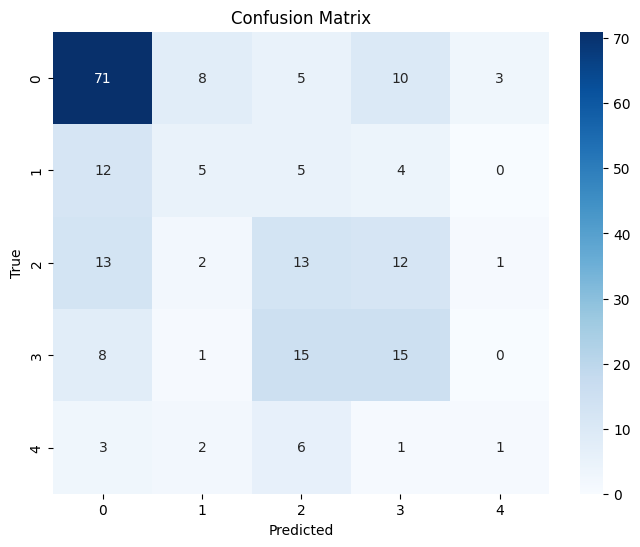

In [ ]:
import seaborn as sns

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# --- 10. SOUMISSION AVEC TTA (Test Time Augmentation) ---
print("Génération de la soumission avec TTA...")
# Recharger le MEILLEUR modèle
model.load_state_dict(torch.load("best_model_sgd_balanced.pth", map_location=DEVICE))
model.eval()

with open(TEST_PATH, "rb") as f:
    test_data = pickle.load(f)

# On crée un Dataset simple pour le test
class TestDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx].astype('uint8'))
        return self.transform(img)

test_ds = TestDataset(test_data['images'], val_transform) # On utilise val_transform
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

preds = []
with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(DEVICE)
        
        # TTA : Moyenne de 3 vues (Originale, Flip H, Flip V)
        out1 = model(imgs)
        out2 = model(torch.flip(imgs, [3])) # Horizontal
        out3 = model(torch.flip(imgs, [2])) # Vertical
        
        avg_out = (out1 + out2 + out3) / 3.0
        _, predicted = torch.max(avg_out, 1)
        preds.extend(predicted.cpu().numpy())

# Création CSV
df = pd.DataFrame({"ID": np.arange(1, len(preds) + 1), "Label": preds})
df.to_csv("IFT3395_YAPS_MCS55.csv", index=False)
print("Fichier 'submission_robust.csv' crée")

Génération de la soumission avec TTA...
Fichier 'submission_robust.csv' crée
